In [1]:
from dypac import dypac
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
import time
from nilearn import datasets
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn import plotting
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr

In [2]:
adhd_dataset = datasets.fetch_adhd(n_subjects=1)
epi_filename = adhd_dataset.func[0]

/home/pbellec/git/nilearn/nilearn/datasets/func.py:509: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [13]:
model = dypac(n_clusters=40, n_states=2, verbose=1, n_init=1, n_init_aggregation=1, n_replications=30, 
              detrend=True, smoothing_fwhm=5, standardize=True)
stab_maps = model.fit(epi_filename)

[MultiNiftiMasker.fit] Loading data from [/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz]
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[dypac] Loading data
[dypac] Replicating clusters on /home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


100%|██████████| 30/30 [00:35<00:00,  1.17s/it]


[dypac] Finding parcellation states
[dypac] Generating state stability maps



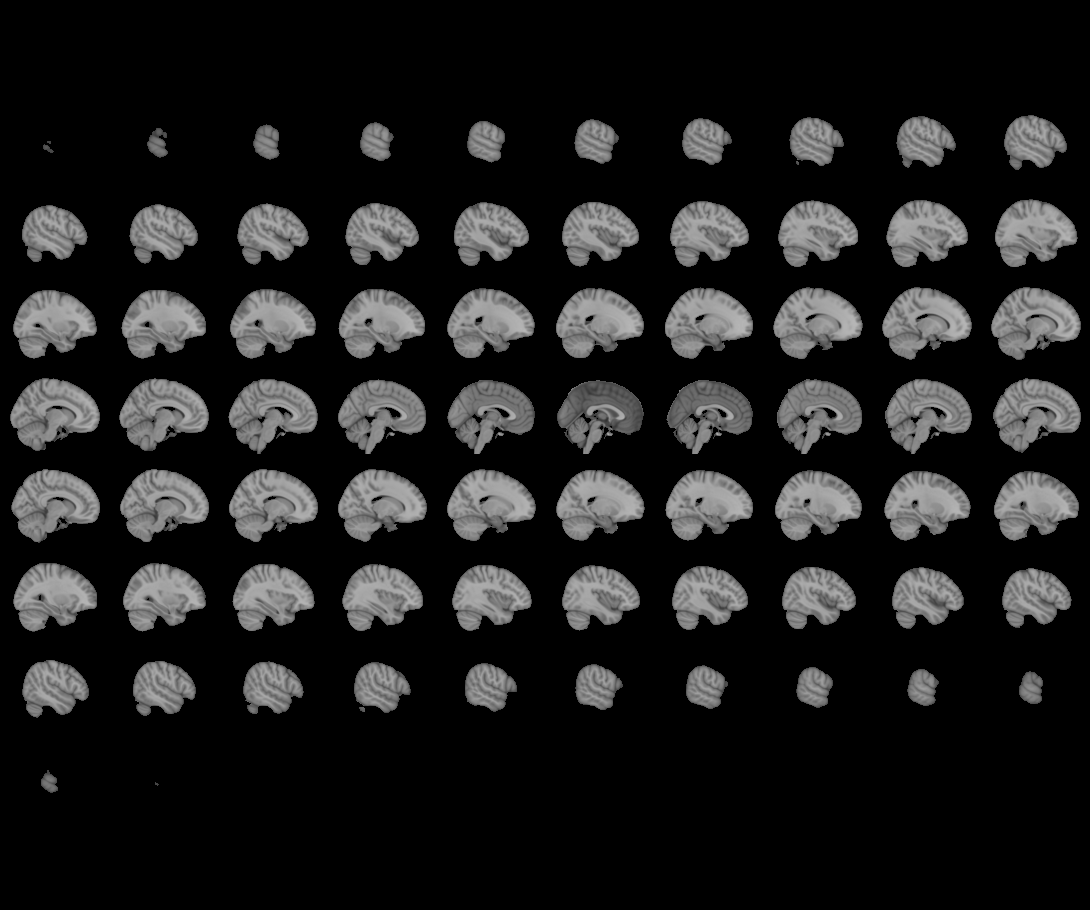
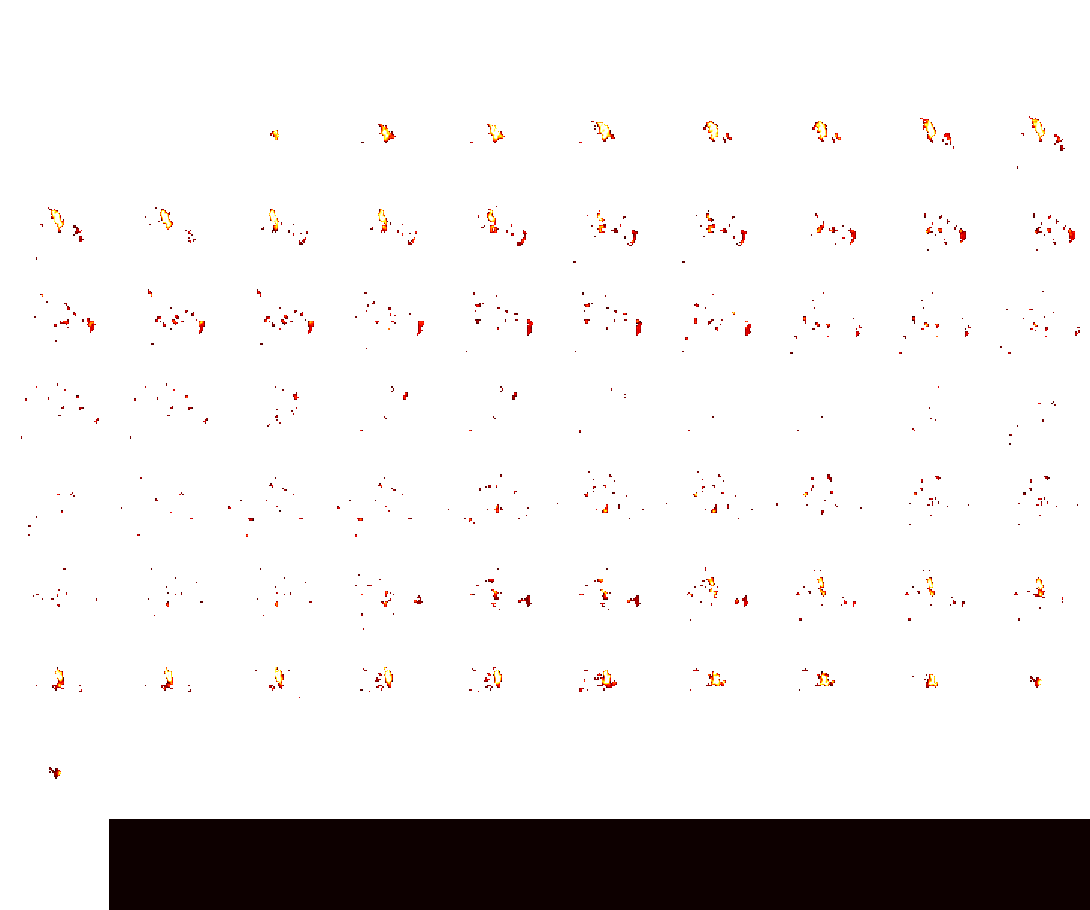

In [14]:
num_comp = 9
comp = model.masker_.inverse_transform(model.components_[num_comp,:].todense())
plotting.view_img(comp, threshold=0.1, vmax=1, title="Dwell time: {dt}".format(dt=model.dwell_time_[num_comp]))

In [15]:
tseries = model.masker_.transform(epi_filename)

[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


In [16]:
weights = model.transform_sparse(epi_filename)

[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


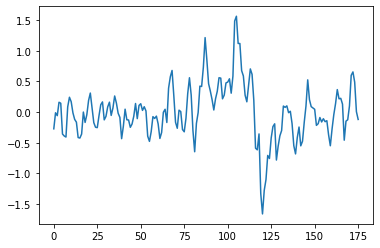

In [7]:
plt.plot(weights[:, num_comp])


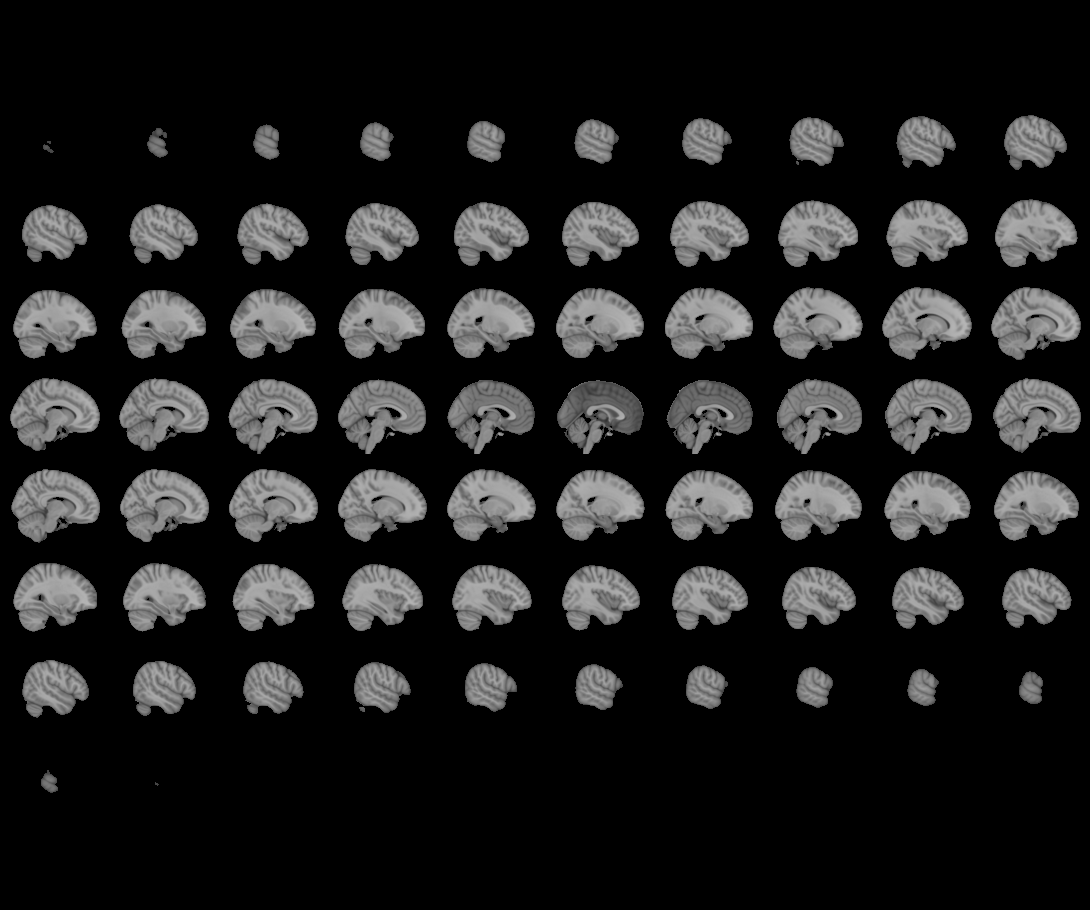
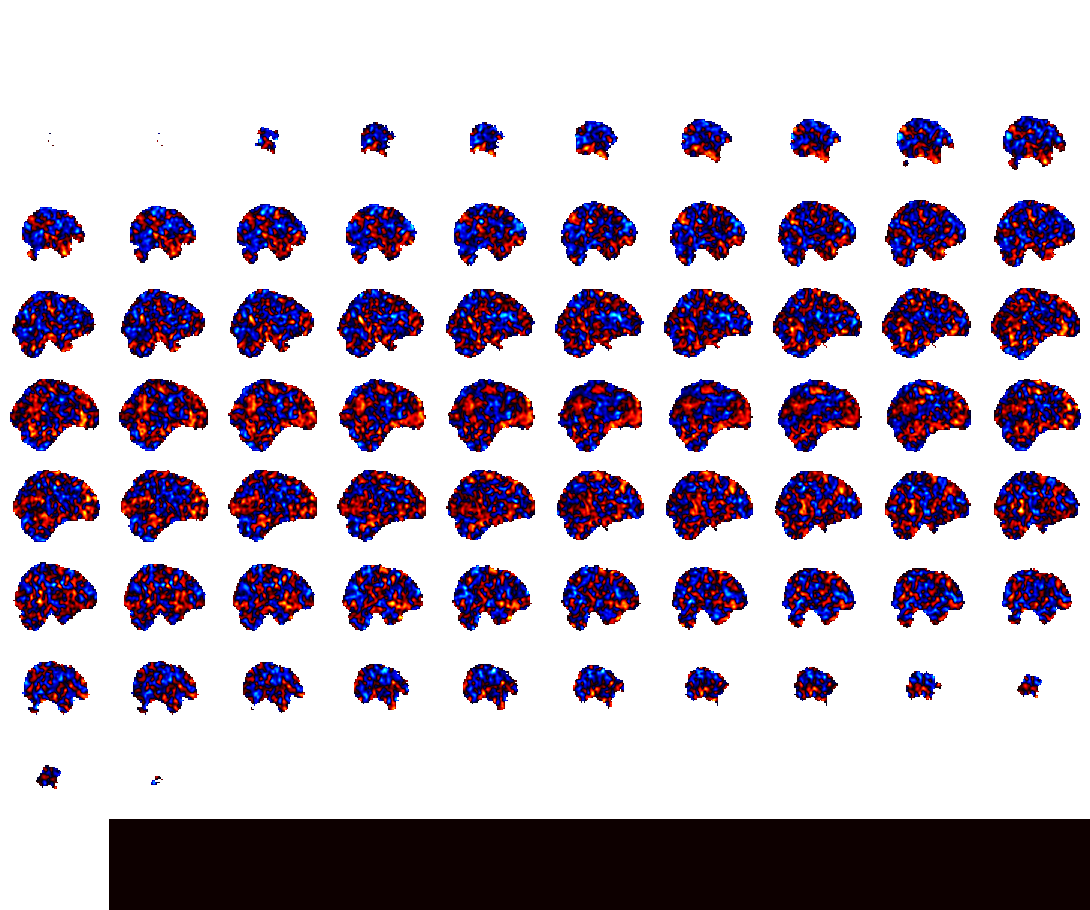

In [17]:
num_t = 50
img = model.masker_.inverse_transform(tseries[num_t,:])
plotting.view_img(img, cut_coords=[2, -22, 10], vmax=4)


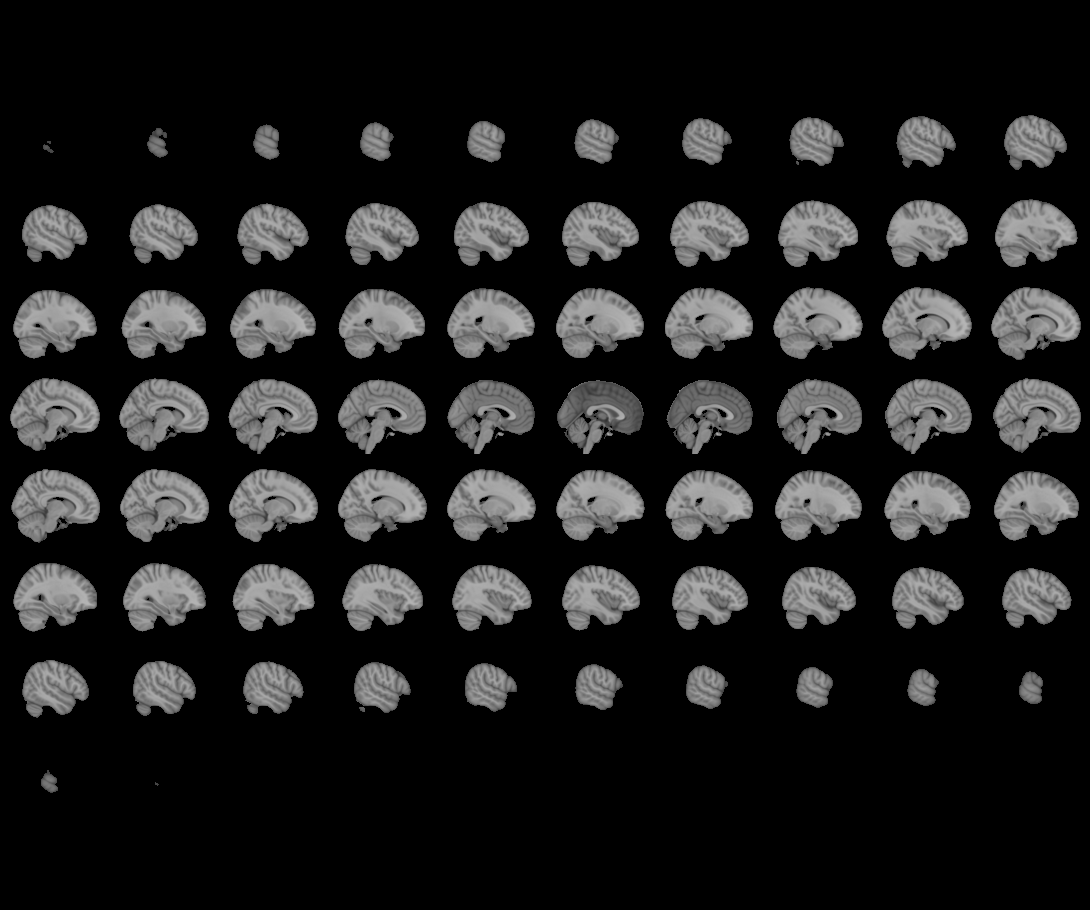
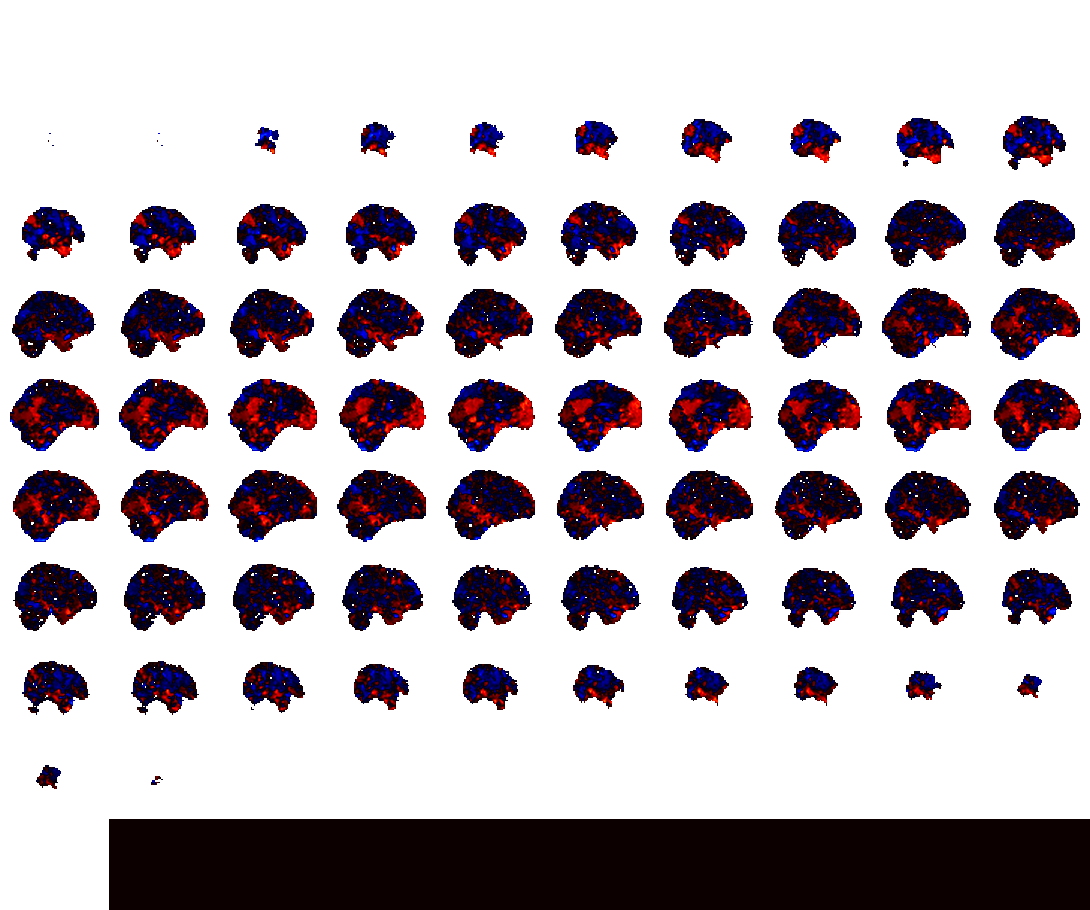

In [18]:
img_r = model.masker_.inverse_transform(weights[num_t,:] * model.components_)
plotting.view_img(img_r, cut_coords=[2, -22, 10], vmax=4)

/home/pbellec/git/nilearn/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



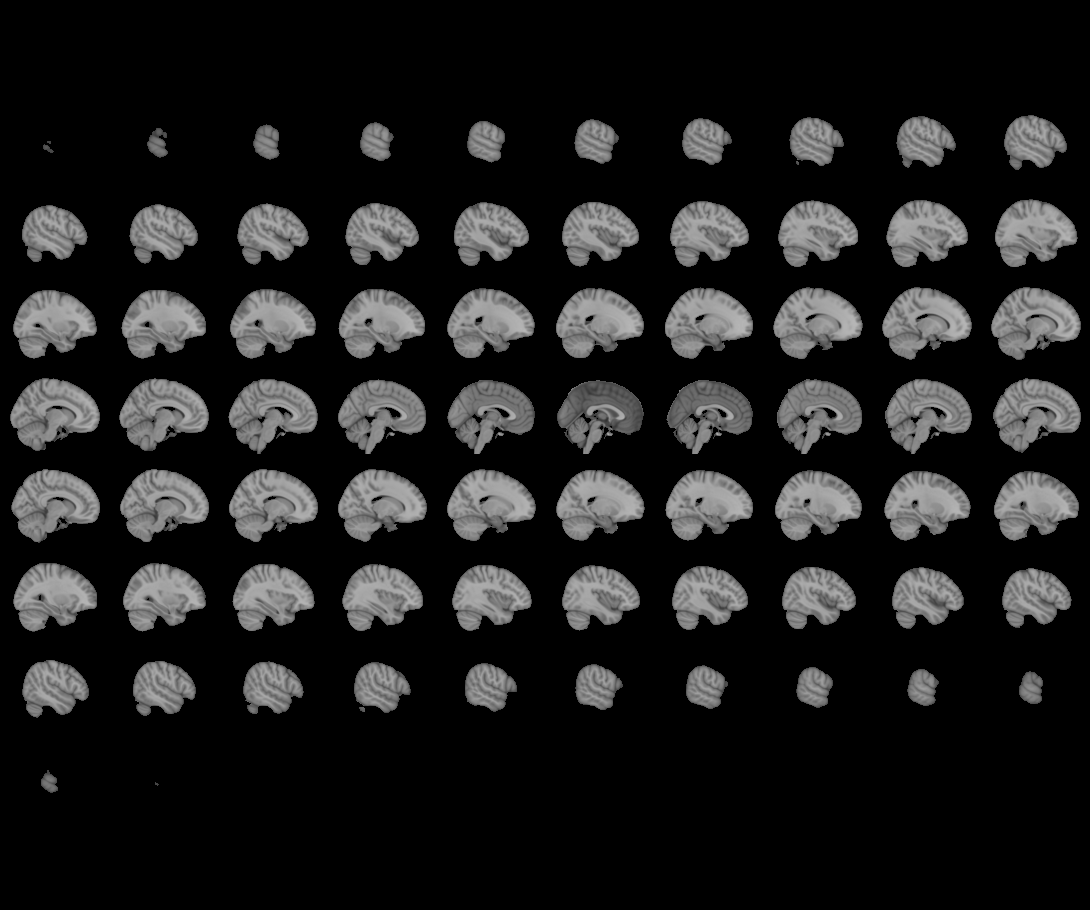
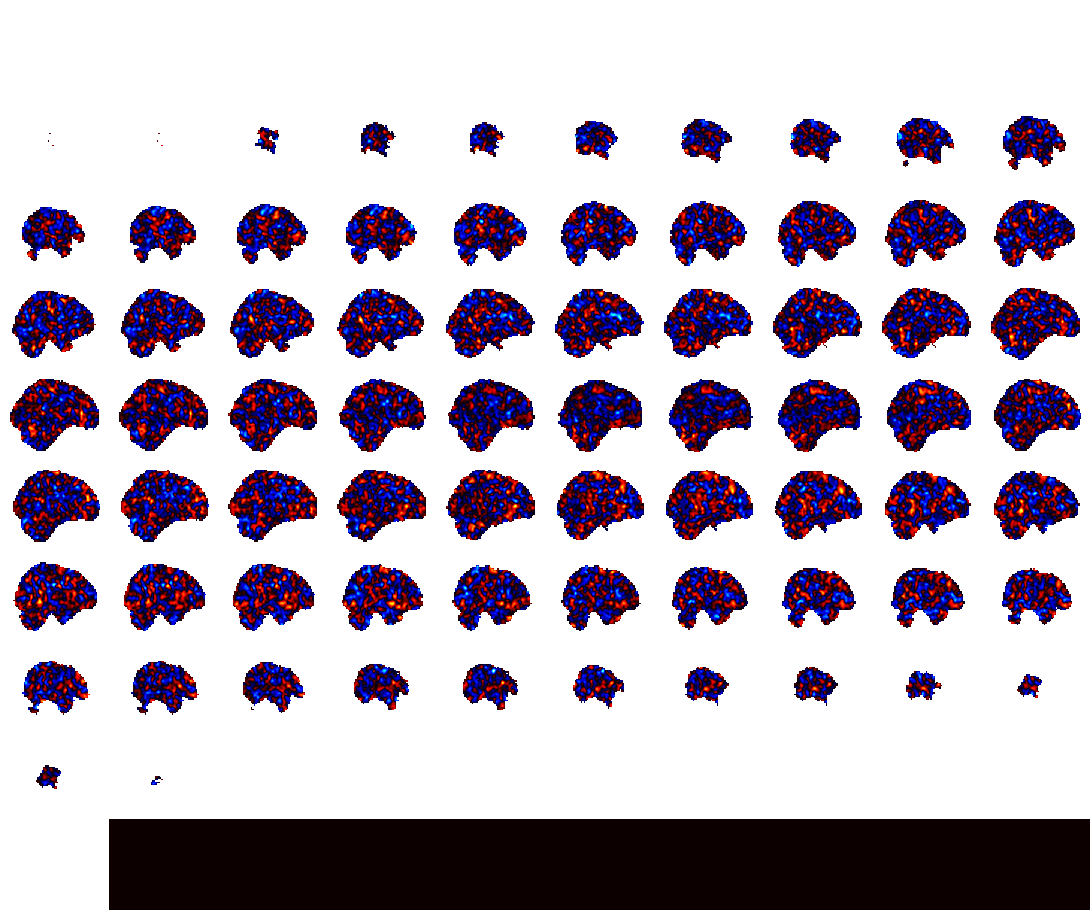

In [19]:
img_diff = image.new_img_like(img, img.get_fdata() - img_r.get_fdata())
plotting.view_img(img_diff, cut_coords=[2, -22, 10], vmax=4)

Let's calculate the original std of the data:

/home/pbellec/git/nilearn/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



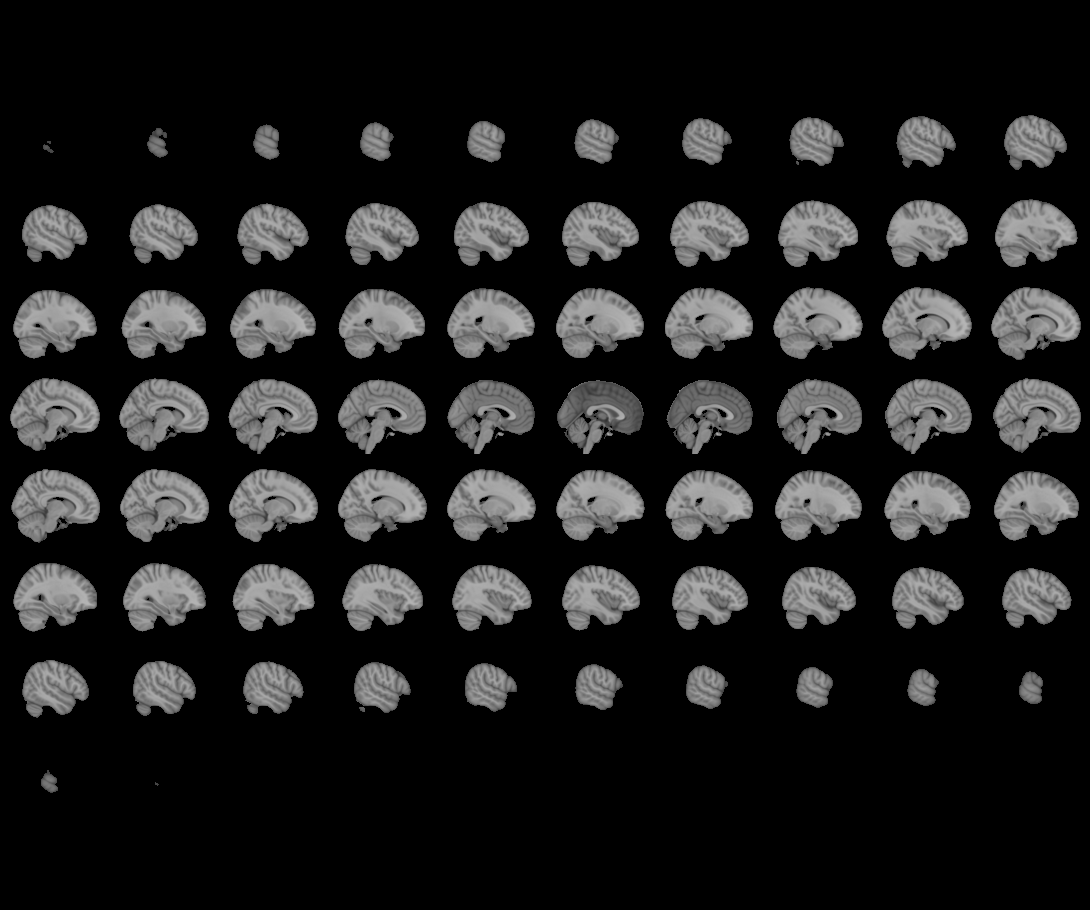
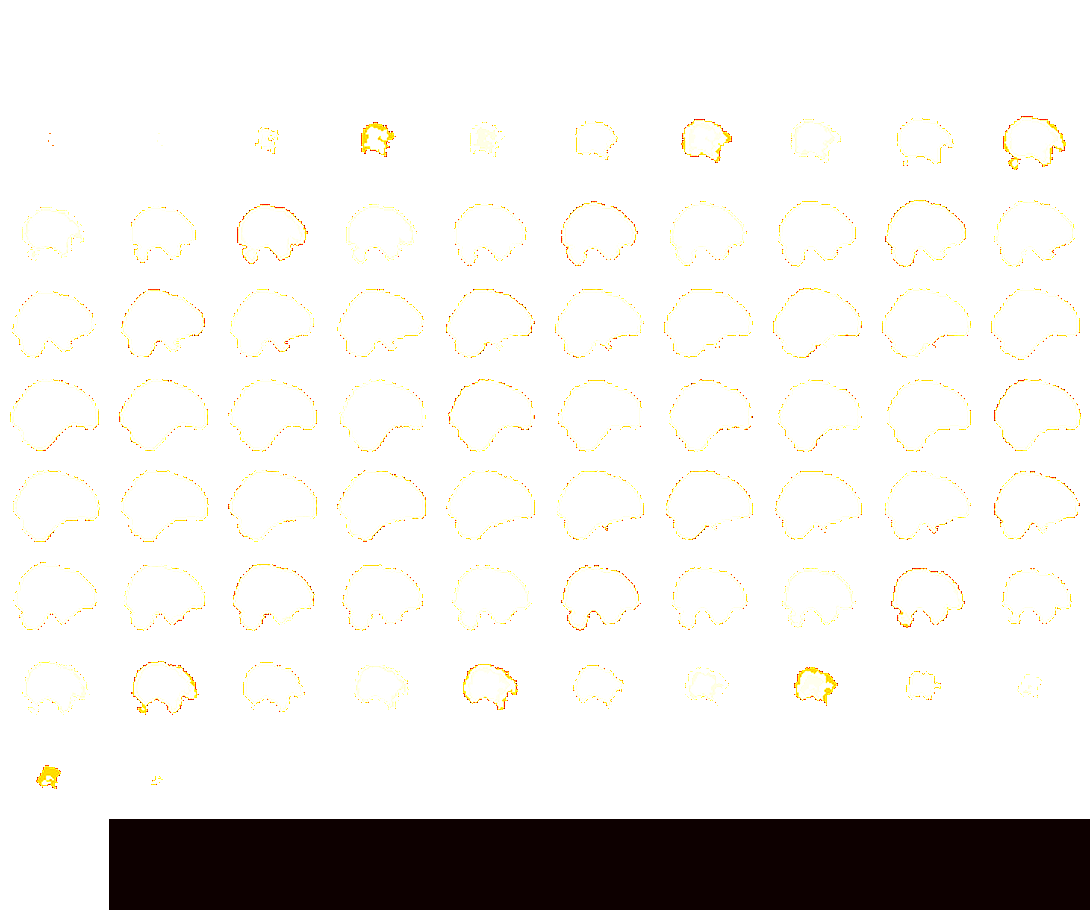

In [20]:
for tt in range(0,tseries.shape[0]):
    img = model.masker_.inverse_transform(tseries[tt, :])
    if (tt==0):
        diff = np.square(img.get_fdata()) # The data is demeaned, so this is a square diff to the mean
    else:
        diff = diff + np.square(img.get_fdata())
img_orig_std = image.new_img_like(img, diff / tseries.shape[0])
plotting.view_img(img_orig_std, cut_coords=[2, -22, 10])

Let's calculate a std image of the residuals:

/home/pbellec/git/nilearn/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



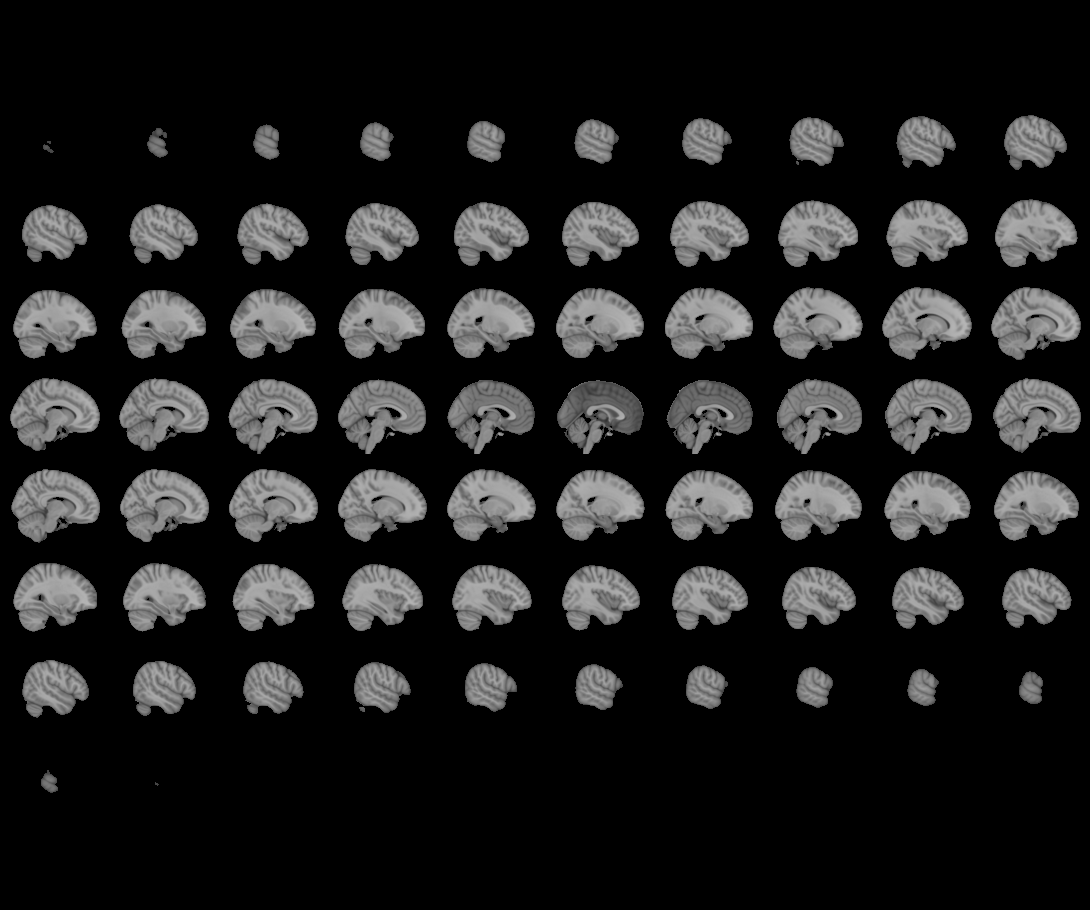
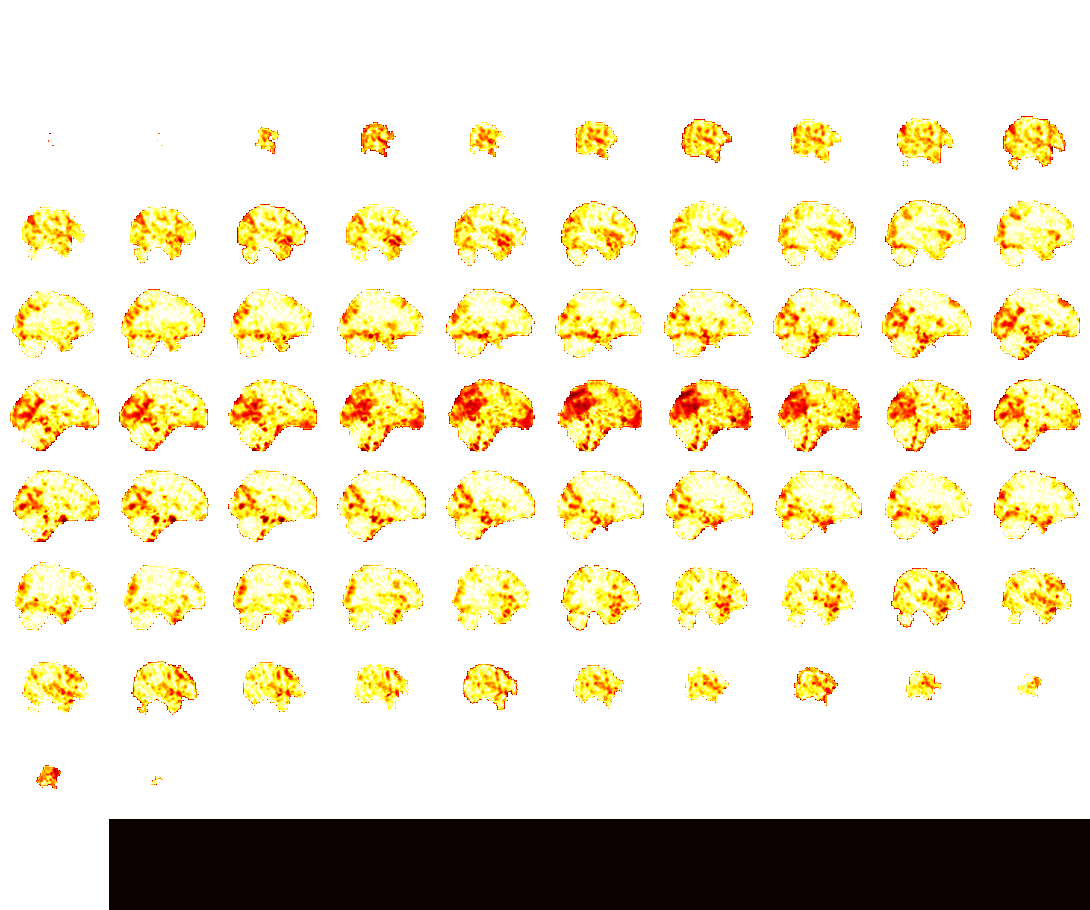

In [21]:
for tt in range(0,tseries.shape[0]):
    img = model.masker_.inverse_transform(tseries[tt, :])
    img_r = model.masker_.inverse_transform(weights[tt,:] * model.components_)
    if (tt==0):
        diff = np.square(img.get_fdata() - img_r.get_fdata())
    else:
        diff = diff + np.square(img.get_fdata() - img_r.get_fdata())
img_std = image.new_img_like(img, diff / tseries.shape[0])
plotting.view_img(img_std, cut_coords=[2, -22, 10], vmax=1)